### Imports

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import gpytorch as gp

from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.stats import skewnorm
from scipy.interpolate import CubicSpline

from typing import List

import warnings
warnings.filterwarnings('ignore')

### Plotting utilities

In [35]:
# set plotting hyperparameters

# set font sizes
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# set linewidths and tick linewidths
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# increase tick length
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

# increase plot line widths
plt.rcParams['lines.linewidth'] = 2

# increase marker sizes
plt.rcParams['lines.markersize'] = 8

# set colors
colors = ['#002147', '#15616D', '#E2C044', '#DE1F1F']

In [36]:
blue_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#002147", "#ffffff"])

def truncate_colormap(
        cmap: matplotlib.colors.Colormap,
        min_val: float = 0.0,
        max_val: float = 1.0,
        n: int = 256,
):
    """
    Truncate a colormap to a specified range.

    Args:
        cmap (matplotlib.colors.Colormap): The colormap to be truncated.
        min_val (float, optional): The minimum value of the colormap range. Defaults to 0.0.
        max_val (float, optional): The maximum value of the colormap range. Defaults to 1.0.
        n (int, optional): The number of colors in the truncated colormap. Defaults to 256.

    Returns:
        matplotlib.colors.Colormap: The truncated colormap.

    Raises:
        None

    Examples:
        # Truncate the 'viridis' colormap to the range [0.2, 0.8] with 128 colors
        new_cmap = truncate_colormap(plt.cm.viridis, min_val=0.2, max_val=0.8, n=128)
    """
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{min_val:.2f},{max_val:.2f})",
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

# Truncate the colormap
blue_cmap = truncate_colormap(blue_cmap, 0., 0.8)

### GP models

In [37]:
# GP model for input data generation

class GPModel(gp.models.ExactGP):
    """
    Gaussian Process model for exact inference.

    Args:
        kernel (gpytorch.kernels.Kernel): The covariance kernel for the GP model.

    Attributes:
        mean_module (gpytorch.means.Mean): The mean module for the GP model.
        covar_module (gpytorch.kernels.Kernel): The covariance module for the GP model.

    """

    def __init__(
            self,
            kernel: gp.kernels.Kernel,
    ):
        """
        Initialize the GPModel.

        Args:
            kernel (gpytorch.kernels.Kernel): The covariance kernel for the GP model.

        """
        # No training data, so pass dummy tensors with shape (1, 1)
        super(GPModel, self).__init__(torch.zeros(1, 1), torch.zeros(1, 1), gp.likelihoods.GaussianLikelihood())
        self.mean_module = gp.means.ZeroMean()
        self.covar_module = kernel

    def forward(
            self,
            x: torch.Tensor,
    ):
        """
        Forward pass of the GPModel.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            gpytorch.distributions.MultivariateNormal: The output distribution.

        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

In [38]:
# GP model for velocity model fusion

class ApproximateGPModel(gp.models.ApproximateGP):
    """
    Approximate Gaussian Process model for variational inference.

    Args:
        inducing_points (torch.Tensor): The inducing points for the variational distribution.

    Attributes:
        mean_module (gpytorch.means.Mean): The mean module for the GP model.
        covar_module (gpytorch.kernels.Kernel): The covariance module for the GP model.

    """

    def __init__(
            self,
            inducing_points: torch.Tensor,
            kernel: gp.kernels.Kernel,
    ):
        """
        Initialize the ApproximateGPModel.

        Args:
            inducing_points (torch.Tensor): The inducing points for the variational distribution.

        """
        variational_distribution = gp.variational.CholeskyVariationalDistribution(
            inducing_points.size(-1)
        )
        variational_strategy = gp.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(kernel)

    def forward(
            self,
            x: torch.Tensor,
    ):
        """
        Forward pass of the ApproximateGPModel.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            gpytorch.distributions.MultivariateNormal: The output distribution.

        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

### Data generation utilities

In [39]:
def sample_gp_prior(
        kernel: gp.kernels.Kernel,
        lengthscale: float,
        n_samples: int = 1,
        x: torch.Tensor = None,
        x_samples: List[torch.Tensor] = None,
):
    """
    Generate samples from a Gaussian Process (GP) prior.

    Parameters:
    - kernel (gpytorch.kernels.Kernel): The kernel function used in the GP model.
    - lengthscale (float or List[float]): The lengthscale(s) of the kernel function. If a single value is provided, it will be used for all samples. If a list is provided, the lengthscale should match the number of samples.
    - n_samples (int): The number of samples to generate from the GP prior. Default is 1.
    - x (torch.Tensor): The input tensor for the GP model. Either `x` or `x_samples` must be specified.
    - x_samples (List[torch.Tensor]): The input tensors for each sample. If not specified, `x` will be used for all samples. The length of `x_samples` should match the number of samples.

    Returns:
    - samples (torch.Tensor): The generated samples from the GP prior.
    
    """
    ...
    if isinstance(lengthscale, (int, float)):
        lengthscale = [lengthscale] * n_samples
    elif len(lengthscale) != n_samples:
        raise ValueError("Number of length scales should match the number of samples")

    if x_samples is None:
        if x is None:
            raise ValueError("Either x or x_samples must be specified")
        x_samples = [x] * n_samples
    elif len(x_samples) != n_samples:
        raise ValueError("Number of x-arrays should match the number of samples")

    samples = torch.Tensor([])
    for i in range(n_samples):
        # Set the GP model with the custom kernel and length scale
        kernel.lengthscale = torch.tensor([lengthscale[i]])
        model = GPModel(kernel)

        # Set the model in eval mode
        model.eval()

        # Sample from the GP model
        with torch.no_grad():
            sample = model(x_samples[i]).rsample()
            samples = torch.cat([samples, sample.unsqueeze(0)], dim=0)

    return samples

In [40]:
def normalise(
        data: torch.Tensor,
        n: float,
        m: float,
):
    """
    Normalizes the given data to a specified range.

    Args:
        data (torch.Tensor): The input data to be normalized.
        n (float): The lower bound of the desired range.
        m (float): The upper bound of the desired range.

    Returns:
        torch.Tensor: The normalized data.

    """

    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    data = data * (m - n) + n

    return data

## Workflow

### Input data generation

In [41]:
def set_seed(seed):

    torch.manual_seed(seed)
    np.random.seed(seed)

    
seed = 0
set_seed(seed)

In [42]:
# PARAMETERS TO CHANGE

DATA_GENERATION_KERNEL = gp.kernels.RBFKernel()
SVGP_FITTING_KERNEL = gp.kernels.RBFKernel()
PPGPR_FITTING_KERNEL = gp.kernels.RBFKernel()

NUM_INDUCING_POINTS = 20
LEARNING_RATE = 0.05
TRAINING_ITERATIONS = 4000

In [43]:
n_points = 25   # number of data points per input velocity model

# minimum and maximum seismic wave speeds in arbitrary units
min_velocity = 3
max_velocity = 7

In [44]:
# create a staggered coordinate grid
# GPs can handle non-gridded data, but we use regularly spaced
# data here for simplicity

x1 = torch.linspace(0., 3.9, n_points)  # coordinates of the first input velocity model
x2 = torch.linspace(0.1, 4., n_points)  # coordinates of the second input velocity model

xs = [x1, x2]

In [45]:
n_samples = len(xs)
lengthscale = [0.6, 0.3]    # lengthscale of the kernel function for each input velocity model

# generate velocity models as samples from the GP prior
velocity_models = sample_gp_prior(DATA_GENERATION_KERNEL, lengthscale, n_samples=n_samples, x_samples=xs)

print(velocity_models.shape)

torch.Size([2, 25])


In [46]:
# second velocity model is a weighted superposition of the two GP samples
# this creates large-scale similarities and smaller-scale differences between the two models
velocity_models[1] = (1 / 3) * velocity_models[1] + (2 / 3) * velocity_models[0]

# normalise the velocity models to the desired range
velocity_models = normalise(velocity_models, min_velocity, max_velocity)

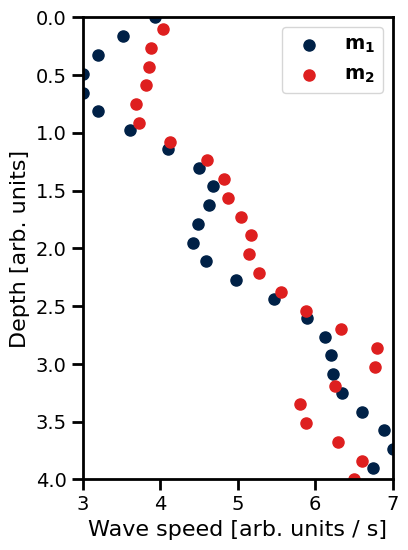

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
ax.scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[3])

ax.set(ylim=(0, 4), xlim=(min_velocity, max_velocity))
ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

ax.invert_yaxis()

ax.legend()

plt.show()

### Training the models

In [48]:
# set the training data
train_x = torch.cat([x for x in xs], dim=0)
train_y = torch.cat([y for y in velocity_models], dim=0)

print(train_x.shape, train_y.shape)

torch.Size([50]) torch.Size([50])


In [49]:
# set initial locations of the inducing points
inducing_points = torch.linspace(0, 4, NUM_INDUCING_POINTS)

# initialize the SVGP and PPGPR models
ppgpr = ApproximateGPModel(inducing_points, PPGPR_FITTING_KERNEL)
svgp = ApproximateGPModel(inducing_points, SVGP_FITTING_KERNEL)

# set Gaussian likelihoods for the models
likelihood_ppgpr = gp.likelihoods.GaussianLikelihood()
likelihood_svgp = gp.likelihoods.GaussianLikelihood()

In [50]:
# UNCOMMENT TO TRAIN THE MODEL
ppgpr.train()
svgp.train()
likelihood_ppgpr.train()
likelihood_svgp.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [51]:
# UNCOMMENT TO TRAIN THE MODEL

# set the optimizers for the models
optimizer_ppgpr = torch.optim.Adam([
    {"params": ppgpr.parameters()},
    {"params": likelihood_ppgpr.parameters()},
], lr=LEARNING_RATE)

optimizer_svgp = torch.optim.Adam([
    {"params": svgp.parameters()},
    {"params": likelihood_svgp.parameters()},
], lr=LEARNING_RATE)

# define the objective functions
mll_ppgpr = gp.mlls.PredictiveLogLikelihood(likelihood_ppgpr, ppgpr, num_data=train_y.numel())
mll_svgp = gp.mlls.VariationalELBO(likelihood_svgp, svgp, num_data=train_y.numel())

In [52]:
# UNCOMMENT TO TRAIN THE MODEL
# train the models

for _ in tqdm(range(TRAINING_ITERATIONS)):
    optimizer_ppgpr.zero_grad()
    output_ppgpr = ppgpr(train_x)
    loss_ppgpr = -mll_ppgpr(output_ppgpr, train_y)
    loss_ppgpr.backward()
    optimizer_ppgpr.step()

for _ in tqdm(range(TRAINING_ITERATIONS)):
    optimizer_svgp.zero_grad()
    output_svgp = svgp(train_x)
    loss_svgp = -mll_svgp(output_svgp, train_y)
    loss_svgp.backward()
    optimizer_svgp.step()

100%|██████████| 4000/4000 [00:27<00:00, 145.96it/s]


In [53]:
# UNCOMMENT IF JUST TRAINED MODEL
# save the models and likelihoods

torch.save(ppgpr.state_dict(), "./trained_models/ppgpr.pth")
torch.save(svgp.state_dict(), "./trained_models/svgp.pth")

torch.save(likelihood_ppgpr.state_dict(), "./trained_models/likelihood_ppgpr.pth")
torch.save(likelihood_svgp.state_dict(), "./trained_models/likelihood_svgp.pth")

# load the models and likelihoods

state_dict_ppgpr = torch.load("./trained_models/ppgpr.pth")
state_dict_svgp = torch.load("./trained_models/svgp.pth")

state_dict_likelihood_ppgpr = torch.load("./trained_models/likelihood_ppgpr.pth")
state_dict_likelihood_svgp = torch.load("./trained_models/likelihood_svgp.pth")

ppgpr = ApproximateGPModel(inducing_points, PPGPR_FITTING_KERNEL)
ppgpr.load_state_dict(state_dict_ppgpr)

svgp = ApproximateGPModel(inducing_points, SVGP_FITTING_KERNEL)
svgp.load_state_dict(state_dict_svgp)

ppgpr.eval()
svgp.eval()

likelihood_ppgpr = gp.likelihoods.GaussianLikelihood()
likelihood_svgp = gp.likelihoods.GaussianLikelihood()

likelihood_ppgpr.load_state_dict(state_dict_likelihood_ppgpr)
likelihood_svgp.load_state_dict(state_dict_likelihood_svgp)

likelihood_ppgpr.eval()
likelihood_svgp.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)